In [6]:
from context import qnetvo as qnet
from context import src

import matplotlib.pyplot as plt
from pennylane import numpy as np

## Loading Data

In [8]:
chain_data_path = "../../script/data/ibm_casablanca_simple_trilocal_chain_opt_parameter_shift/"

chain_data_files = src.get_data_files(chain_data_path, r".*")
chain_opt_dicts = [qnet.read_optimization_json(file) for file in chain_data_files]
print("num chain optimizations : ", len(chain_data_files))

star_data_path = "../../script/data/ibm_casablanca_simple_trilocal_star_opt_parameter_shift/"

star_data_files = src.get_data_files(star_data_path, r".*")
star_opt_dicts = [qnet.read_optimization_json(file) for file in star_data_files]
print("num star optimizations : ", len(star_data_files))


num chain optimizations :  6
num star optimizations :  5


## Chain Ansatz

In [14]:
chain_prep_nodes = [
    qnet.PrepareNode(1, [0, 1], qnet.ghz_state, 0),
    qnet.PrepareNode(1, [2, 3], qnet.ghz_state, 0),
    qnet.PrepareNode(1, [4, 5], qnet.ghz_state, 0),
]
chain_meas_nodes = [
    qnet.MeasureNode(2, 2, [0], qnet.local_RY, 1),
    qnet.MeasureNode(2, 2, [1, 2], qnet.local_RY, 2),
    qnet.MeasureNode(2, 2, [3, 4], qnet.local_RY, 2),
    qnet.MeasureNode(2, 2, [5], qnet.local_RY, 1),
]

trilocal_chain_ansatz = qnet.NetworkAnsatz(chain_prep_nodes, chain_meas_nodes)
trilocal_chain_cost = qnet.nlocal_chain_cost_22(trilocal_chain_ansatz)

## Star Ansatz

In [9]:
star_prep_nodes = [
    qnet.PrepareNode(1, [0, 3], qnet.ghz_state, 0),
    qnet.PrepareNode(1, [1, 4], qnet.ghz_state, 0),
    qnet.PrepareNode(1, [2, 5], qnet.ghz_state, 0),
]
star_meas_nodes = [
    qnet.MeasureNode(2, 2, [0], qnet.local_RY, 1),
    qnet.MeasureNode(2, 2, [1], qnet.local_RY, 1),
    qnet.MeasureNode(2, 2, [2], qnet.local_RY, 1),
    qnet.MeasureNode(2, 2, [3, 4, 5], qnet.local_RY, 3),
]

trilocal_star_ansatz = qnet.NetworkAnsatz(star_prep_nodes, star_meas_nodes)
trilocal_star_cost = qnet.nlocal_star_22_cost_fn(trilocal_star_ansatz)

# Plots

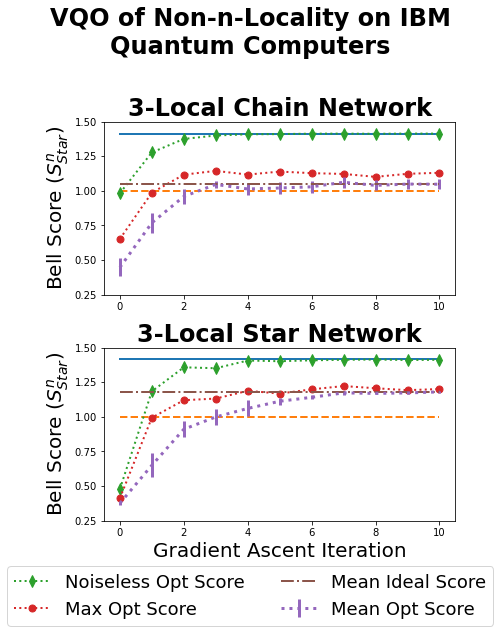

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))

fig.suptitle("VQO of Non-n-Locality on IBM\nQuantum Computers", size=24, fontweight="bold")


yticks = [0.25,0.5,0.75,1,1.25,1.5]

num_samples = 11

chain_data = src.opt_dicts_mean_stderr(chain_opt_dicts, num_samples)
chain_ideal_scores = [
    -(trilocal_chain_cost(chain_data["opt_settings"][i])) for i in range(num_samples)
]

ax1.plot(range(num_samples), [np.sqrt(2)]*num_samples, "-", linewidth=2)
ax1.plot(range(num_samples), [1]*num_samples, "--", linewidth=2)
ax1.plot(range(num_samples), chain_ideal_scores, ":d", markersize=8, linewidth=2, label="Noiseless Opt Score")
ax1.plot(range(num_samples), chain_data["max_scores"], ":o", markersize=7 , linewidth=2, label="Max Opt Score")
ax1.errorbar(
    range(num_samples),
    chain_data["mean_scores"],
    chain_data["stderr_scores"],
    linestyle=":",
    linewidth=3,
    label="Mean Opt Score"
)
ax1.plot(
    range(num_samples),
    [chain_data["mean_theoretical_score"]] * num_samples,
    "-.",
    label="Mean Ideal Score",
    linewidth=2
)

ax1.set_title("\n3-Local Chain Network", size=24, fontweight="bold")
# ax1.set_xlabel("Gradient Ascent Iteration", size=20)
ax1.set_ylabel(r"Bell Score ($S_{Star}^n$)", size=20)
ax1.set_yticks(yticks)

fig.legend(ncol=2, loc="lower center", fontsize=18, bbox_to_anchor=(0.5, -0.11))


star_data = src.opt_dicts_mean_stderr(star_opt_dicts, num_samples)
star_ideal_scores = [
    -(trilocal_star_cost(star_data["opt_settings"][i])) for i in range(num_samples)
]

ax2.plot(range(num_samples), [np.sqrt(2)]*num_samples, "-", linewidth=2)
ax2.plot(range(num_samples), [1]*num_samples, "--", linewidth=2)
ax2.plot(range(num_samples), star_ideal_scores, ":d", markersize=8, linewidth=2, label="Max Score\nNoise Removed")
ax2.plot(range(num_samples), star_data["max_scores"], ":o", markersize=7 , linewidth=2, label="Max Noisy Score")
ax2.errorbar(
    range(num_samples),
    star_data["mean_scores"],
    star_data["stderr_scores"],
    linestyle=":",
    linewidth=3,
    label="Mean Score"
)
ax2.plot(
    range(num_samples),
    [star_data["mean_theoretical_score"]] * num_samples,
    "-.",
    label="Mean Noisy\nTheoretical Bound",
    linewidth=2
)

ax2.set_title("3-Local Star Network", size=24, fontweight="bold")
ax2.set_xlabel("Gradient Ascent Iteration", size=20)
ax2.set_ylabel(r"Bell Score ($S_{Star}^n$)", size=20)
ax2.set_yticks(yticks)

plt.tight_layout()
plt.show()